# Structural variations with optical DNA maps

This jupyter notebook works as a framework for a possible supplementary for the future paper on structural variations using optical DNA maps and was written as part of Jupyter Notebooks course https://github.com/mlund/jupyter-course . Notation is used as in the cited papers at the bottom of the notebook.



## Running the notebook

To run this notebook, install and activate the `dnasvenv` environment described by the file [`dnasvenv.yml`](/dnasvenv.yml) by running the following in a terminal:

```bash
conda env create -f dnasvenv.yml
source activate dnasvenv
```
    

In [9]:
import hmmpackage as hm
import numpy as np
import matplotlib.pyplot as plt

## Simulation of Optical DNA maps

### Known sequence

In the DNA barcoding experiments considered here, DNA is stained with YOYO-1 and netropsin, with a ratio roughly 1:6. DNA is then stretched in nanochannels with dimensions of $100\times 150 \text{nm}^2$ and a length of $500
 \mu$m by using pressure-driven flow created from nitrogen gas. Then $n$ time-frames of the molecule are obtained using EMCCD camera combined with an inverted fluorescence microscope.

If the DNA sequence is known, a mathematical model (in this case a competitive binding model) can be used to simulate the expected output of the experiment. Then a DNA sequence of $k_{\rm max}$ basepairs is converted into a probability vector

\begin{equation} \mathbf p = \{ p(k), k = \overline{0,k_{\max}-1}\},\end{equation}

which gives us the probabilities that a YOYO-1 is bound to a particular
basepair along the DNA. Given this probability vector, $\mathbf p$, a theoretical
barcode is computed as a convolution of $\mathbf p$ with a Gaussian kernel $\boldsymbol{\phi}$ with a width of $\sigma$ bps:

\begin{equation}\boldsymbol{\phi} = \left\{ e^{-\frac{k^2}{2\sigma^2}}, \begin{cases} |k| \leq \lfloor \frac{k_{\rm max}}{2} \rfloor , k_{max} \text{ odd} \\ -\frac{k_{\rm max}}{2}<k \leq \frac{k_{\rm max}}{2}, k_{max} \text{ even}\end{cases}\right\}
\end{equation}

here $\sigma$  regulates how wide the Gaussian is. This convolution is now written according to

\begin{equation}
\tilde{I} (k) = (\mathbf p * \boldsymbol \phi) (k) = \sum_{i=0}^{k_{\rm max}-1}p(i)\cdot \phi(i-k),~ 0 \leq k \leq k_{\rm max}-1 ~
\end{equation}

Finally, the result of this convolution is downsampled to bp/px convertion ratio of the experiment.


In [10]:
# "We use SeqIO to to input file data 
from Bio import SeqIO

filename = "data/DA15001-pUUH_Sequence.fasta"

fasta_sequences = SeqIO.parse(open(filename),'fasta')
for fasta in fasta_sequences:
    name, sequence = fasta.id, str(fasta.seq)

In [11]:
# plasmid sequence
ntSeq = sequence
plasmid = hm.cb_transfer_matrix_method(ntSeq)

9.72796010971
[0.7543299  0.74760922 0.87645351 ... 0.89051023 0.74538796 0.74255989]


In [12]:
psf = 300
nmbp = 0.25
nmpx = 159.2
bar =  hm.seq_to_timeseries(plasmid,len(plasmid),psf/nmbp)

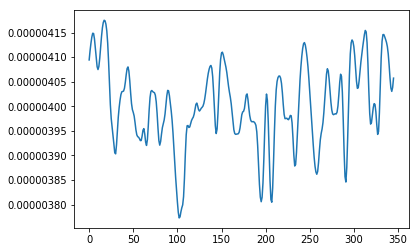

In [13]:
# https://stackoverflow.com/questions/13728392/moving-average-or-running-mean
N = int(round(nmpx/nmbp))
import pandas as pd

output = pd.Series(bar).rolling(window=N).mean().iloc[N-1:].values
len(output)

f = plt.figure # TODO: make this plot publication ready
# plt.plot(bar)
plt.plot(output[::N])

### Unknown sequence

If underlying DNA sequence is not known, one can simulate random DNA maps using the structure described above. Instead of calculating the probability vector, we generate $k_{\max}$ Normally distributed random numbers, and convolve with a Gaussian

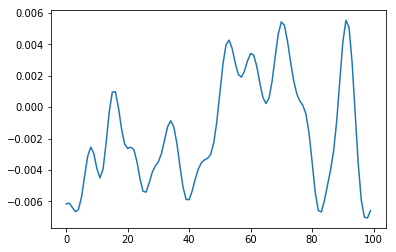

In [14]:
barLen = 100 # TODO: add a slider so we can make this longer
seq = np.random.normal(0,1,barLen)
bar =  hm.seq_to_timeseries(seq,barLen,2.3)

f = plt.figure # TODO: make this plot publication ready
plt.plot(bar)


### Structural variation

A third important case of optical maps is when the sequence is known (or is known to be in some database), but there is some structural variation in the data, for example inversion, insertion, translocation or deletion. The goal of this project is to predict such structural variations in both simulated datasets and experimental datasets. 

We use $n$ samples of each structural variation generated previously, and stored in the samples folder. We read this using numpy.



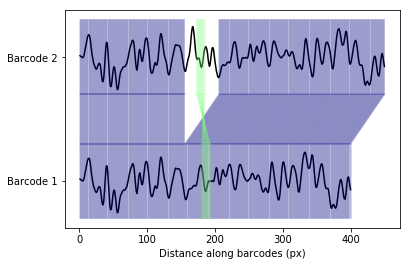

In [15]:
# use pandas instead here
f = open( 'data/samples/Insertion/7_sample1_seq.txt','r' )
x = f.readlines()
f.close()
y = [u.split() for u in x]

seq1 = np.array(y[0]).astype(float)
seq1 = np.reshape(seq1,(-1,len(seq1)))
seq2 = np.array(y[1]).astype(float)
seq2 = np.reshape(seq2,(-1,len(seq2)))

# # Example 1: circular shift
vitTraceback, W, score = hm.compute_example(seq1, seq2)

M = len(seq1[0])
resTable = hm.parse_vtrace(vitTraceback, M)
if resTable[-1][1][-1] == resTable[0][1][0]-M+1:
    resTable[0][0].append(resTable[-1][0])
    resTable[0][1].append(resTable[-1][1])
    resTable[-1][0] = []
    resTable[-1][1] = []


# matchStates - 1-M and M+1-2M
hm.plot_comparison(seq1, seq2, resTable)

# here could include subplot with the correct alignment (so remove the extra thing)

## Alignment significance using random variations
Here we generate distribution based on random segments

In [ ]:
# import hmmpackage as hm

# # load txt file example
# # name = 'samples/Insertion/9_sample1_seq.txt'
# fold = 'data/samples/Random/'
# urls = hm.find_txts_in_dir(fold)

# totScores = []
# for i in urls:
#     print(i)
#     # name = 'samples/Random/9_sample1_seq.txt'
#     name = i
#     seq1, seq2 = hm.sim_txt(name)

#     # run msv algorithm
#     resTable,segScores = hm.vit_to_table(seq1,seq2)
#     totScores.append(segScores)

# # matchStates - 1-M and M+1-2M
# hm.plot_comparison(seq1, seq2, resTable)

# tt =[]
# for i in range(0,len(totScores)):
#     for j in range(0,len(totScores[i])):
#         tt.append(totScores[i][j])

# import numpy as np
# import matplotlib.mlab as mlab
# import matplotlib.pyplot as plt



# # https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.genextreme.html
# plt.figure()
# from scipy.stats import genextreme as gev
# # the histogram of the data
# n, bins, patches = plt.hist(tt, 40, facecolor='green', alpha=0.75)
# plt.show()
# plt.xlabel('Viterbi score')
# plt.ylabel('Count')
# plt.title('Viterbi score histogram for random fragment comparison')

# fit = gev.fit(tt,loc=3)


## Alignment with experiment data


## Conclusions

### References

EDDY, Sean R.. . Profile hidden Markov models. Bioinformatics (Oxford, England), 1998, 14.9: 755-763.

DVIRNAS, Albertas, et al. Facilitated sequence assembly using densely labeled optical DNA barcodes: A combinatorial auction approach. PloS one, 2018, 13.3: e0193900.